<a href="https://www.kaggle.com/code/patilaakash619/tesla-stock-price-prediction?scriptVersionId=216380015" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a id="4"></a>
<div class="alert alert-block alert-info">
    <h2 style="text-align: center; color: black;">Step 1: Import Libraries 🛠️</h2>
</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as XGBRegressor
import warnings
warnings.filterwarnings('ignore')

<a id="4"></a>
<div class="alert alert-block alert-info">
    <h2 style="text-align: center; color: black;">Step 2: Data Loading 🛠️</h2>
</div>

In [2]:
df=pd.read_csv("/kaggle/input/tesla-stock-data-2024/TESLA.csv")

In [3]:
print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
print(df.head())
print("\nData Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())

Dataset Shape: (3637, 8)

First few rows:
   Unnamed: 0     Date      Open      High       Low     Close  Adj Close  \
0           0  6/29/10  1.266667  1.666667  1.169333  1.592667   1.592667   
1           1  6/30/10  1.719333  2.028000  1.553333  1.588667   1.588667   
2           2   7/1/10  1.666667  1.728000  1.351333  1.464000   1.464000   
3           3   7/2/10  1.533333  1.540000  1.247333  1.280000   1.280000   
4           4   7/6/10  1.333333  1.333333  1.055333  1.074000   1.074000   

      Volume  
0  281494500  
1  257806500  
2  123282000  
3   77097000  
4  103003500  

Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3637 entries, 0 to 3636
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  3637 non-null   int64  
 1   Date        3637 non-null   object 
 2   Open        3637 non-null   float64
 3   High        3637 non-null   float64
 4   Low         3637 non-null   float64


<a id="4"></a>
<div class="alert alert-block alert-info">
    <h2 style="text-align: center; color: black;">Step 3: Data Preprocessing 🛠️</h2>
</div>

In [4]:
def preprocess_data(df):
    # Convert Date to datetime
    df['Date'] = pd.to_datetime(df['Date'])
    
    # Create time-based features
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day
    df['DayOfWeek'] = df['Date'].dt.dayofweek
    
    # Calculate technical indicators
    df['MA7'] = df['Close'].rolling(window=7).mean()
    df['MA30'] = df['Close'].rolling(window=30).mean()
    df['MA90'] = df['Close'].rolling(window=90).mean()
    
    # Calculate price changes
    df['Price_Change'] = df['Close'].pct_change()
    df['Volume_Change'] = df['Volume'].pct_change()
    
    # Calculate volatility
    df['Volatility'] = df['Price_Change'].rolling(window=30).std()
    
    # Drop missing values
    df = df.dropna()
    
    return df

<a id="4"></a>
<div class="alert alert-block alert-info">
    <h2 style="text-align: center; color: black;">Step 4: Feature Engineering 🛠️</h2>
</div>

In [5]:
def create_features(df):
    # Create target variable (next day's closing price)
    df['Target'] = df['Close'].shift(-1)
    
    # Select features for modeling
    features = ['Open', 'High', 'Low', 'Close', 'Volume', 'MA7', 'MA30', 'MA90', 
                'Price_Change', 'Volume_Change', 'Volatility', 'Year', 'Month', 'Day', 'DayOfWeek']
    
    # Prepare X and y
    X = df[features].iloc[:-1]  # Remove last row since we don't have target for it
    y = df['Target'].iloc[:-1]
    
    return X, y

<a id="4"></a>
<div class="alert alert-block alert-info">
    <h2 style="text-align: center; color: black;">Step 5: Model Training and Evaluation 🛠️</h2>
</div>

In [6]:
def train_evaluate_models(X, y):
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Initialize models
    models = {
        'Linear Regression': LinearRegression(),
        'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
        'XGBoost': XGBRegressor.XGBRegressor(n_estimators=100, random_state=42)
    }
    
    results = {}
    predictions = {}
    
    # Train and evaluate each model
    for name, model in models.items():
        # Train model
        model.fit(X_train_scaled, y_train)
        
        # Make predictions
        train_pred = model.predict(X_train_scaled)
        test_pred = model.predict(X_test_scaled)
        predictions[name] = test_pred
        
        # Calculate metrics
        results[name] = {
            'Train R2': r2_score(y_train, train_pred),
            'Test R2': r2_score(y_test, test_pred),
            'Train RMSE': np.sqrt(mean_squared_error(y_train, train_pred)),
            'Test RMSE': np.sqrt(mean_squared_error(y_test, test_pred)),
            'Train MAE': mean_absolute_error(y_train, train_pred),
            'Test MAE': mean_absolute_error(y_test, test_pred)
        }
    
    return results, predictions, y_test, X_test.index

<a id="4"></a>
<div class="alert alert-block alert-info">
    <h2 style="text-align: center; color: black;">Step 6: Visualization Functions 🛠️</h2>
</div>

In [7]:
def plot_stock_trends(df):
    plt.figure(figsize=(15, 10))
    
    # Plot stock prices
    plt.subplot(2, 1, 1)
    plt.plot(df['Date'], df['Close'], label='Close Price')
    plt.plot(df['Date'], df['MA7'], label='7-day MA')
    plt.plot(df['Date'], df['MA30'], label='30-day MA')
    plt.plot(df['Date'], df['MA90'], label='90-day MA')
    plt.title('Tesla Stock Price Trends')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    
    # Plot volume
    plt.subplot(2, 1, 2)
    plt.bar(df['Date'], df['Volume'], alpha=0.5)
    plt.title('Trading Volume')
    plt.xlabel('Date')
    plt.ylabel('Volume')
    
    plt.tight_layout()
    plt.show()

def plot_model_predictions(predictions, y_test, test_dates):
    plt.figure(figsize=(15, 6))
    plt.plot(test_dates, y_test, label='Actual', alpha=0.7)
    
    for name, pred in predictions.items():
        plt.plot(test_dates, pred, label=f'{name} Predictions', alpha=0.7)
    
    plt.title('Model Predictions vs Actual Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

def plot_correlation_matrix(df):
    plt.figure(figsize=(12, 8))
    correlation_matrix = df[['Open', 'High', 'Low', 'Close', 'Volume', 'MA7', 'MA30', 'MA90']].corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix of Features')
    plt.tight_layout()
    plt.show()

# Main execution pipeline
def run_analysis(df):
    # Preprocess data
    processed_df = preprocess_data(df)
    
    # Create features
    X, y = create_features(processed_df)
    
    # Train and evaluate models
    results, predictions, y_test, test_dates = train_evaluate_models(X, y)
    
    # Generate visualizations
    plot_stock_trends(processed_df)
    plot_correlation_matrix(processed_df)
    plot_model_predictions(predictions, y_test, test_dates)
    
    # Print model evaluation metrics
    print("\nModel Evaluation Metrics:")
    for model_name, metrics in results.items():
        print(f"\n{model_name}:")
        for metric_name, value in metrics.items():
            print(f"{metric_name}: {value:.4f}")
    
    return results, predictions, processed_df

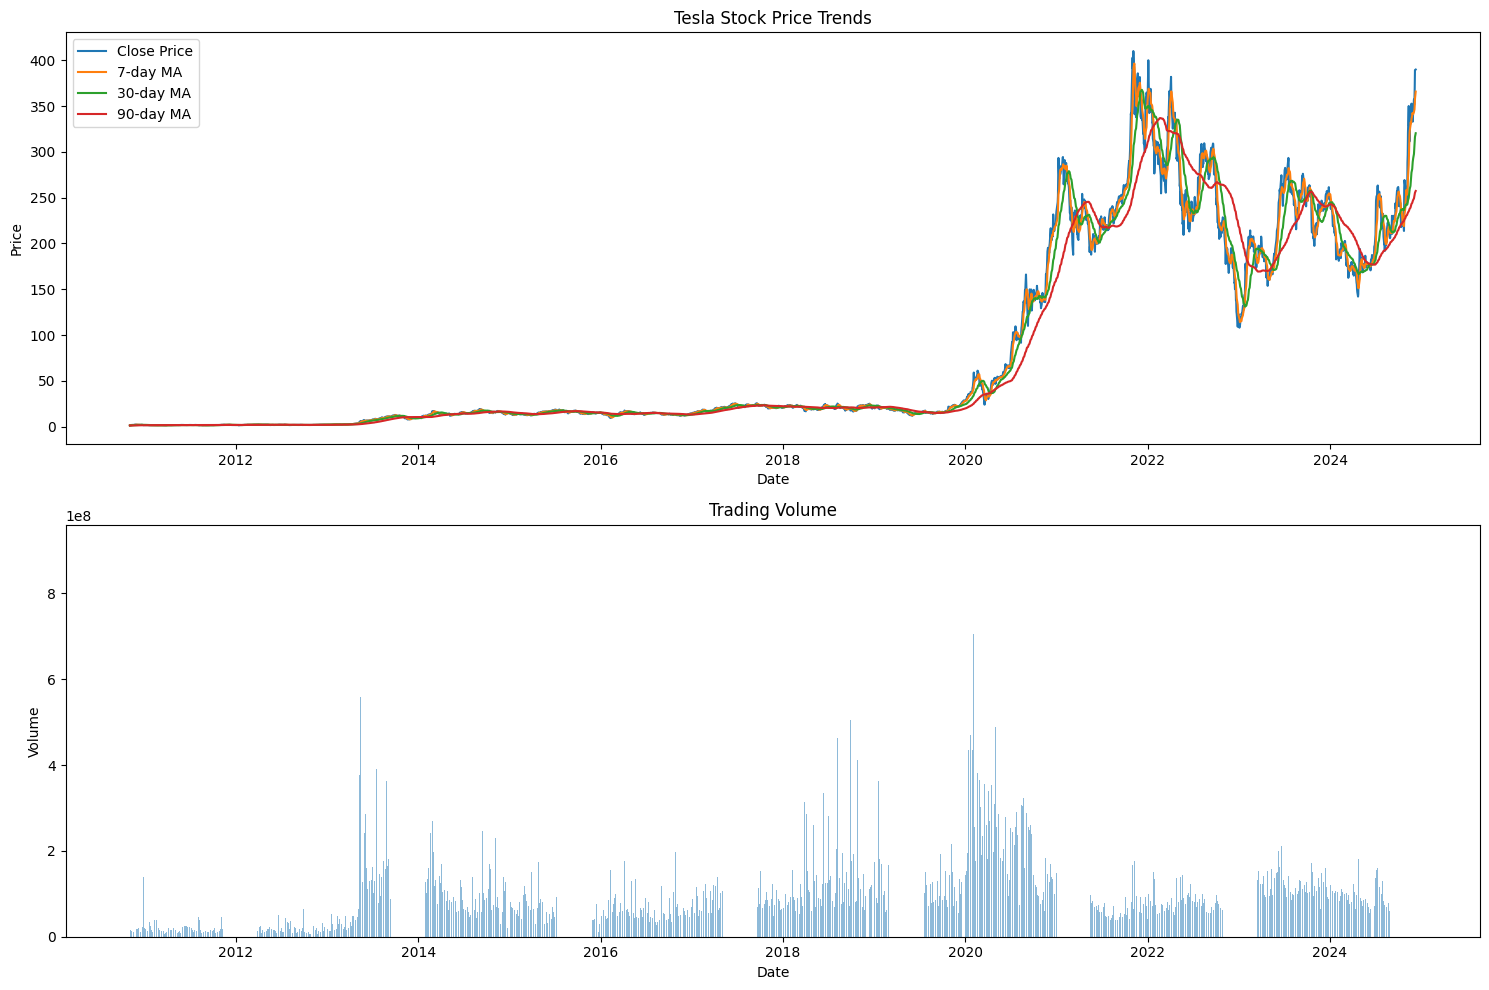

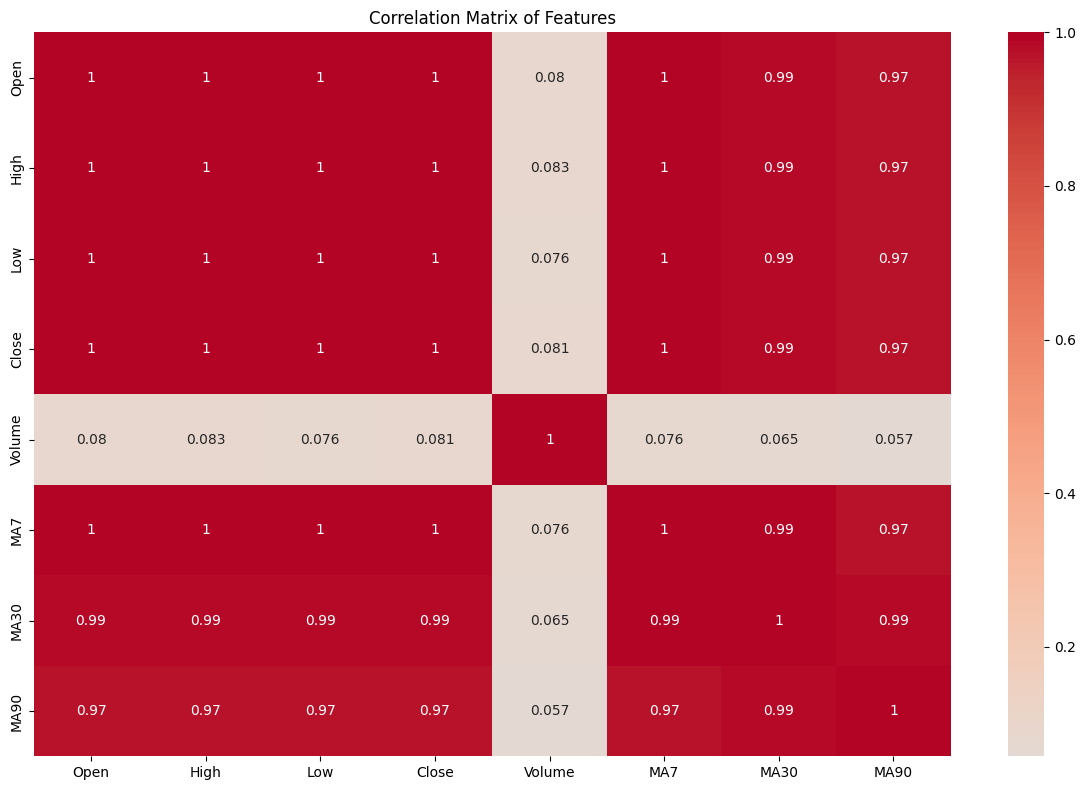

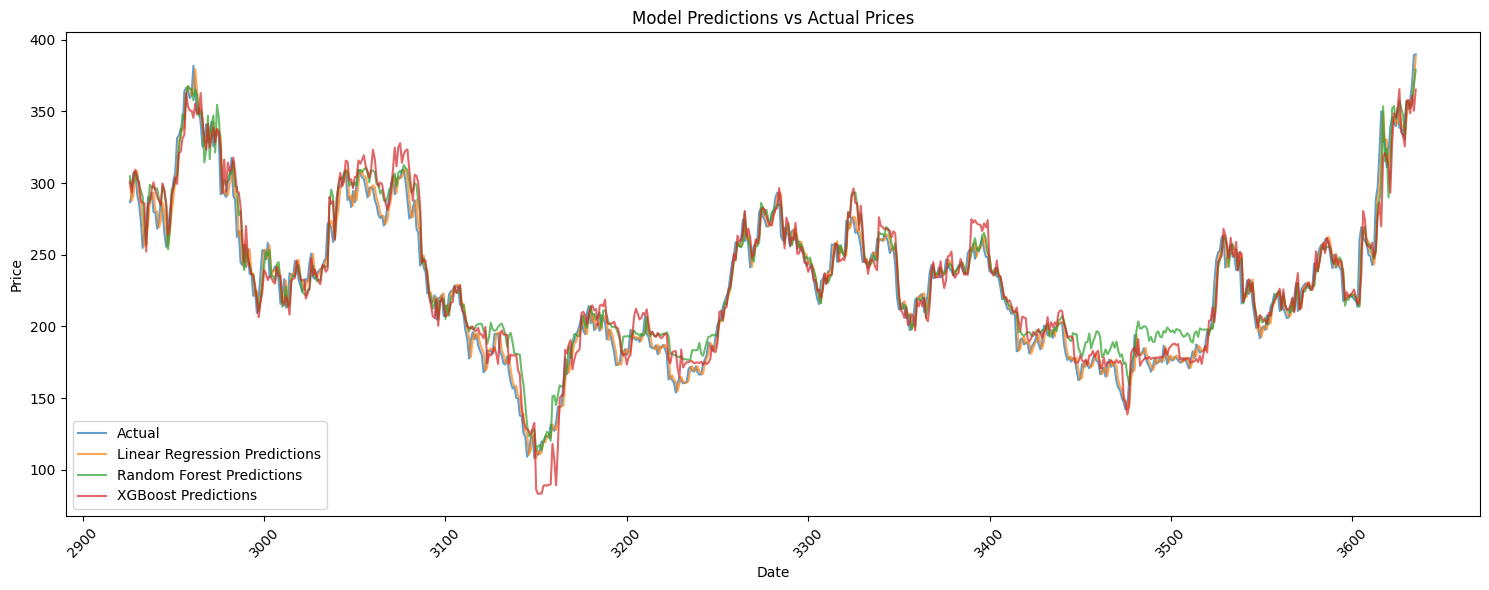


Model Evaluation Metrics:

Linear Regression:
Train R2: 0.9980
Test R2: 0.9709
Train RMSE: 3.5945
Test RMSE: 8.8842
Train MAE: 1.3279
Test MAE: 6.4732

Random Forest:
Train R2: 0.9997
Test R2: 0.9347
Train RMSE: 1.4703
Test RMSE: 13.3088
Train MAE: 0.4936
Test MAE: 10.3604

XGBoost:
Train R2: 1.0000
Test R2: 0.9273
Train RMSE: 0.2238
Test RMSE: 14.0392
Train MAE: 0.1503
Test MAE: 10.5934


In [8]:
# Run the analysis pipeline
results, predictions, processed_df = run_analysis(df)